In [1]:
# ===================== Core Libraries =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import date

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

# ===================== Sklearn Utilities =====================
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import (
    StandardScaler,
    PowerTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# ===================== Models =====================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# ===================== Metrics =====================
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# ===================== Imbalanced Learning =====================
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ===================== Hyperparameter Optimization =====================
import optuna
from optuna.samplers import TPESampler

# ===================== Model Persistence =====================
import joblib


In [33]:
# Read data
df = pd.read_csv(r"Visadataset.csv")


# creating the date object of today's date
todays_date = date.today()
current_year= todays_date.year

# create new col
df['company_age'] = current_year-df['yr_of_estab']

# drop irrelavant col
df = df.drop(['yr_of_estab', 'case_id'], axis=1)

df

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,Asia,High School,N,N,14513,West,592.2029,Hour,Y,Denied,19
1,Asia,Master's,Y,N,2412,Northeast,83425.6500,Year,Y,Certified,24
2,Asia,Bachelor's,N,Y,44444,West,122996.8600,Year,Y,Denied,18
3,Asia,Bachelor's,N,N,98,West,83434.0300,Year,Y,Denied,129
4,Africa,Master's,Y,N,1082,South,149907.3900,Year,Y,Certified,21
...,...,...,...,...,...,...,...,...,...,...,...
25475,Asia,Bachelor's,Y,Y,2601,South,77092.5700,Year,Y,Certified,18
25476,Asia,High School,Y,N,3274,Northeast,279174.7900,Year,Y,Certified,20
25477,Asia,Master's,Y,N,1121,South,146298.8500,Year,N,Certified,116
25478,Asia,Master's,Y,Y,1918,West,86154.7700,Year,Y,Certified,139


In [34]:
# define numerical & categorical columns
numerical_cols = df.select_dtypes(exclude=['object', 'category']).columns.to_list()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.to_list()

# print columns
print(numerical_cols)
print(categorical_cols)

['no_of_employees', 'prevailing_wage', 'company_age']
['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position', 'case_status']


no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

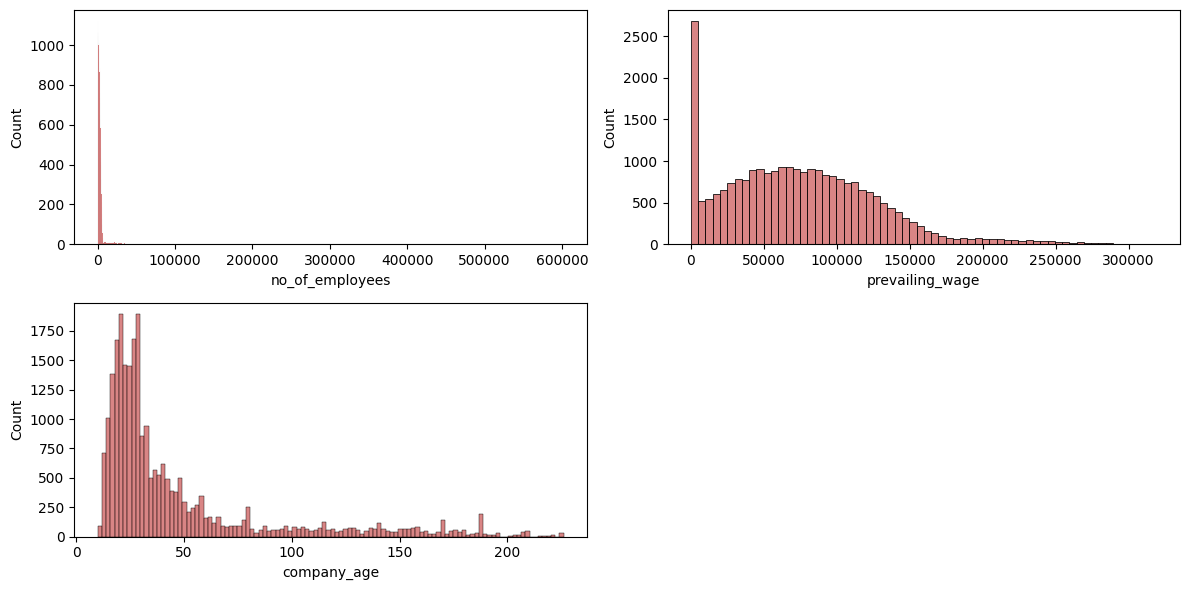

In [35]:
# distribution of numeric data 
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=df[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

# Check Skewness
df[numerical_cols].skew(axis=0, skipna=True)

In [36]:
# ==================== DEFINE YOUR COLUMNS ====================

# Columns that need power transformation to handle skewness.
power_transform_cols = ['company_age', 'no_of_employees']

# Ordinal categorical columns
ordinal_columns = ['education_of_employee']

# Define the order for ordinal categories (VERY IMPORTANT!)
ordinal_categories = [
    ['High School', "Master's", "Bachelor's", 'Doctorate']   # education_of_employee
    # Adjust these based on your actual data values and their logical order
]

# Nominal categorical columns
nominal_columns = ['continent', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']

 

In [37]:

# ==================== CUSTOM TRANSFORMERS ====================

class OutlierHandler(BaseEstimator, TransformerMixin):
    """Cap outliers using IQR method"""
    
    def __init__(self, method='cap', factor=1.5):
        self.method = method
        self.factor = factor
        self.lower_bounds = {}
        self.upper_bounds = {}
    
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        
        for col in X_df.columns:
            if pd.api.types.is_numeric_dtype(X_df[col]):
                Q1 = X_df[col].quantile(0.25)
                Q3 = X_df[col].quantile(0.75)
                IQR = Q3 - Q1
                
                self.lower_bounds[col] = Q1 - self.factor * IQR
                self.upper_bounds[col] = Q3 + self.factor * IQR
        
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X.copy()
        
        for col in self.lower_bounds.keys():
            if col in X_df.columns:
                X_df[col] = X_df[col].clip(
                    lower=self.lower_bounds[col],
                    upper=self.upper_bounds[col]
                )
        
        return X_df if isinstance(X, pd.DataFrame) else X_df.values


class CorrelationRemoverNumeric(BaseEstimator, TransformerMixin):
    """Remove highly correlated NUMERICAL features"""
    
    def __init__(self, threshold=0.9, numerical_cols=None):
        self.threshold = threshold
        self.numerical_cols = numerical_cols
        self.columns_to_drop = []
        self.columns_to_keep = []
    
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        
        # Select only numerical columns for correlation analysis
        if self.numerical_cols:
            X_numeric = X_df[self.numerical_cols]
        else:
            X_numeric = X_df.select_dtypes(include=[np.number])
        
        # Calculate correlation matrix
        corr_matrix = X_numeric.corr().abs()
        
        # Get upper triangle
        upper_triangle = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        
        # Find correlated features
        self.columns_to_drop = [
            column for column in upper_triangle.columns 
            if any(upper_triangle[column] > self.threshold)
        ]
        
        # Keep track of remaining columns
        self.columns_to_keep = [col for col in X_df.columns 
                                if col not in self.columns_to_drop]
        
        if self.columns_to_drop:
            print(f"Dropping correlated columns: {self.columns_to_drop}")
        
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X.copy()
        X_df = X_df[self.columns_to_keep]
        return X_df if isinstance(X, pd.DataFrame) else X_df.values


class DynamicColumnTransformer(BaseEstimator, TransformerMixin):
    """Dynamically adjust preprocessing based on remaining columns after correlation removal"""
    
    def __init__(self, numerical_cols, power_transform_cols, 
                 ordinal_cols, ordinal_categories, nominal_cols):
        
        self.numerical_cols = numerical_cols
        self.power_transform_cols = power_transform_cols
        self.ordinal_cols = ordinal_cols
        self.ordinal_categories = ordinal_categories  # List of lists for each ordinal column
        self.nominal_cols = nominal_cols
        
        self.remaining_numerical_cols = None
        self.remaining_power_cols = None
        self.preprocessor = None
    
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        
        # Determine remaining numerical columns after correlation removal
        self.remaining_numerical_cols = [
            col for col in self.numerical_cols 
            if col in X_df.columns and col not in self.power_transform_cols
        ]
        
        self.remaining_power_cols = [
            col for col in self.power_transform_cols 
            if col in X_df.columns
        ]
        
        print(f"\nRemaining numerical cols (standard): {self.remaining_numerical_cols}")
        print(f"Remaining power transform cols: {self.remaining_power_cols}")
        print(f"Ordinal cols: {self.ordinal_cols}")
        print(f"Nominal cols: {self.nominal_cols}")
        
        # Build transformers list
        transformers = []
        
        # Standard numerical features (no power transform)
        if self.remaining_numerical_cols:
            numerical_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ])
            transformers.append(('num', numerical_pipeline, self.remaining_numerical_cols))
        
        # Numerical features with power transformation
        if self.remaining_power_cols:
            power_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('power', PowerTransformer(method='yeo-johnson')),
                ('scaler', StandardScaler())
            ])
            transformers.append(('power', power_pipeline, self.remaining_power_cols))
        
        # Ordinal categorical features
        if self.ordinal_cols:
            ordinal_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ordinal_encoder', OrdinalEncoder(
                    categories=self.ordinal_categories,
                    handle_unknown='use_encoded_value',
                    unknown_value=-1  # Assign -1 to unknown categories during inference
                ))
            ])
            transformers.append(('ordinal', ordinal_pipeline, self.ordinal_cols))
        
        # Nominal categorical features
        if self.nominal_cols:
            nominal_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot_encoder', OneHotEncoder(
                    drop='first',  # Avoid multicollinearity
                    sparse_output=False,
                    handle_unknown='ignore'  # Ignore unknown categories during inference
                ))
            ])
            transformers.append(('nominal', nominal_pipeline, self.nominal_cols))
        
        # Create ColumnTransformer
        self.preprocessor = ColumnTransformer(
            transformers=transformers,
            remainder='drop'  # Drop any columns not specified
        )
        
        self.preprocessor.fit(X_df, y)
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        return self.preprocessor.transform(X_df)


In [38]:
# ==================== EVALUATION FUNCTION ====================

def evaluate_clf(true, predicted, predicted_proba=None):

    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted, average='binary')
    precision = precision_score(true, predicted, average='binary')
    recall = recall_score(true, predicted, average='binary')
    
    # Use predicted probabilities if available, otherwise use predicted labels
    if predicted_proba is not None:
        roc_auc = roc_auc_score(true, predicted_proba)
    else:
        roc_auc = roc_auc_score(true, predicted)
    
    return {
        'accuracy': acc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc
    }

In [39]:
# ==================== Pipeline function ========================================

def create_pipeline(model, numerical_cols, power_transform_cols, 
                   ordinal_columns, ordinal_categories, nominal_columns):
    """Create preprocessing + SMOTE + model pipeline"""
    
    pipeline = ImbPipeline([
        ('outlier_handler', OutlierHandler(method='cap', factor=1.5)),
        ('correlation_remover', CorrelationRemoverNumeric(
            threshold=0.9, 
            numerical_cols=numerical_cols
        )),
        ('preprocessor', DynamicColumnTransformer(
            numerical_cols=numerical_cols,
            power_transform_cols=power_transform_cols,
            ordinal_cols=ordinal_columns,
            ordinal_categories=ordinal_categories,
            nominal_cols=nominal_columns
        )),
        ('smote', SMOTE(
            sampling_strategy='auto',
            random_state=42,
            k_neighbors=5
        )),
        ('model', model)
    ])
    
    return pipeline

In [40]:
# ==================== OPTUNA OBJECTIVE FUNCTIONS ====================

def objective_random_forest(trial, X_train, y_train):
    """Optuna objective for Random Forest"""
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42
    }
    
    model = RandomForestClassifier(**params)
    pipeline = create_pipeline(model, numerical_cols, power_transform_cols,
                              ordinal_columns, ordinal_categories, nominal_columns)
    
    # Use cross-validation for robust evaluation
    cv_scores = cross_val_score(pipeline, X_train, y_train, 
                                cv=3, scoring='roc_auc', n_jobs=-1)
    
    return cv_scores.mean()


def objective_decision_tree(trial, X_train, y_train):
    """Optuna objective for Decision Tree"""
    
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_categorical('max_depth', [None, 5, 10, 20, 30]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
        'random_state': 42
    }
    
    model = DecisionTreeClassifier(**params)
    pipeline = create_pipeline(model, numerical_cols, power_transform_cols,
                              ordinal_columns, ordinal_categories, nominal_columns)
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, 
                                cv=3, scoring='roc_auc', n_jobs=-1)
    
    return cv_scores.mean()


def objective_gradient_boosting(trial, X_train, y_train):
    """Optuna objective for Gradient Boosting"""
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'random_state': 42
    }
    
    model = GradientBoostingClassifier(**params)
    pipeline = create_pipeline(model, numerical_cols, power_transform_cols,
                              ordinal_columns, ordinal_categories, nominal_columns)
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, 
                                cv=3, scoring='roc_auc', n_jobs=-1)
    
    return cv_scores.mean()


def objective_logistic_regression(trial, X_train, y_train):
    """Optuna objective for Logistic Regression - Corrected"""
    
    # Suggest penalty - use None (not 'none')
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', None])
    
    # Choose compatible solver
    if penalty == 'l1':
        solver = 'saga'
    elif penalty == 'l2':
        solver = trial.suggest_categorical('solver_l2', ['lbfgs', 'saga', 'sag', 'newton-cg'])
    elif penalty == 'elasticnet':
        solver = 'saga'
    else:  # penalty is None
        solver = trial.suggest_categorical('solver_none', ['lbfgs', 'saga', 'sag', 'newton-cg'])
    
    params = {
        'penalty': penalty,
        'C': trial.suggest_float('C', 0.01, 100, log=True),
        'solver': solver,
        'max_iter': trial.suggest_int('max_iter', 1000, 3000),
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Add l1_ratio only for elasticnet
    if penalty == 'elasticnet':
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 0.0, 1.0)
    
    try:
        model = LogisticRegression(**params)
        pipeline = create_pipeline(model, numerical_cols, power_transform_cols,
                                  ordinal_columns, ordinal_categories, nominal_columns)
        
        cv_scores = cross_val_score(pipeline, X_train, y_train, 
                                    cv=3, scoring='roc_auc', n_jobs=-1)
        return cv_scores.mean()
    except Exception as e:
        print(f"⚠️ Trial failed with parameters: {params}")
        print(f"   Error: {e}")
        return 0.0


def objective_knn(trial, X_train, y_train):
    """Optuna objective for K-Neighbors"""
    
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 15),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    }
    
    model = KNeighborsClassifier(**params)
    pipeline = create_pipeline(model, numerical_cols, power_transform_cols,
                              ordinal_columns, ordinal_categories, nominal_columns)
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, 
                                cv=3, scoring='roc_auc', n_jobs=-1)
    
    return cv_scores.mean()


def objective_xgboost(trial, X_train, y_train):
    """Optuna objective for XGBoost"""
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.3),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 2),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    
    model = XGBClassifier(**params)
    pipeline = create_pipeline(model, numerical_cols, power_transform_cols,
                              ordinal_columns, ordinal_categories, nominal_columns)
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, 
                                cv=3, scoring='roc_auc', n_jobs=-1)
    
    return cv_scores.mean()


def objective_catboost(trial, X_train, y_train):
    """Optuna objective for CatBoost"""
    
    params = {
        'iterations': trial.suggest_int('iterations', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 7),
        'border_count': trial.suggest_categorical('border_count', [32, 64, 128]),
        'random_state': 42,
        'verbose': False
    }
    
    model = CatBoostClassifier(**params)
    pipeline = create_pipeline(model, numerical_cols, power_transform_cols,
                              ordinal_columns, ordinal_categories, nominal_columns)
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, 
                                cv=3, scoring='roc_auc', n_jobs=-1)
    
    return cv_scores.mean()


def objective_svc(trial, X_train, y_train):
    """Optuna objective for SVC"""
    
    params = {
        'C': trial.suggest_float('C', 0.1, 100, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'random_state': 42,
        'probability': True  # Required for predict_proba
    }
    
    if params['kernel'] == 'poly':
        params['degree'] = trial.suggest_int('degree', 2, 4)
    
    model = SVC(**params)
    pipeline = create_pipeline(model, numerical_cols, power_transform_cols,
                              ordinal_columns, ordinal_categories, nominal_columns)
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, 
                                cv=3, scoring='roc_auc', n_jobs=-1)
    
    return cv_scores.mean()


def objective_adaboost(trial, X_train, y_train):
    """Optuna objective for AdaBoost - Simplified"""
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'random_state': 42
        # algorithm defaults to 'SAMME' if not specified
    }
    
    model = AdaBoostClassifier(**params)
    pipeline = create_pipeline(model, numerical_cols, power_transform_cols,
                              ordinal_columns, ordinal_categories, nominal_columns)
    
    try:
        cv_scores = cross_val_score(pipeline, X_train, y_train, 
                                    cv=3, scoring='roc_auc', n_jobs=-1)
        return cv_scores.mean()
    except Exception as e:
        print(f"⚠️ AdaBoost trial failed: {e}")
        return 0.0

In [41]:
# ==================== MAIN TRAINING FUNCTION ====================

def train_and_evaluate_models(X_train, X_test, y_train, y_test, n_trials=50, timeout=None):
    '''
    Gives every models (best param version) metrics, pipeline, study.
    '''
    # Define models and their objective functions
    model_objectives = {
        'Random Forest': objective_random_forest,
        'Decision Tree': objective_decision_tree,
        'Gradient Boosting': objective_gradient_boosting,
        'Logistic Regression': objective_logistic_regression,
        'K-Neighbors Classifier': objective_knn,
        'XGBoost': objective_xgboost,
        'CatBoost': objective_catboost,
        'Support Vector Classifier': objective_svc,
        'AdaBoost': objective_adaboost
    }
    
    results = []
    best_models = {}
    studies = {}
    
    print("="*80)
    print("STARTING HYPERPARAMETER OPTIMIZATION WITH OPTUNA")
    print("="*80)
    
    for model_name, objective_func in model_objectives.items():
        print(f"\n{'='*80}")
        print(f"Training: {model_name}")
        print(f"{'='*80}")
        
        # Create Optuna study
        study = optuna.create_study(
            direction='maximize',  # Maximize ROC AUC
            sampler=TPESampler(seed=42),
            study_name=f'{model_name}_optimization'
        )
        
        # Optimize
        study.optimize(
            lambda trial: objective_func(trial, X_train, y_train),
            n_trials=n_trials,
            timeout=timeout,
            show_progress_bar=True
        )
        
        # Get best parameters
        best_params = study.best_params
        best_cv_score = study.best_value
        
        print(f"\n✅ Best CV ROC AUC: {best_cv_score:.4f}")
        print(f"Best Parameters: {best_params}")
        
        # Train final model with best parameters on full training data
        if model_name == 'Random Forest':
            final_model = RandomForestClassifier(**best_params)
        elif model_name == 'Decision Tree':
            final_model = DecisionTreeClassifier(**best_params)
        elif model_name == 'Gradient Boosting':
            final_model = GradientBoostingClassifier(**best_params)

        elif model_name == 'Logistic Regression':
            # Clean up parameter names (remove optuna suffixes like 'solver_l2')
            clean_params = {}
            for key, value in best_params.items():
                if key.startswith('solver_'):
                    clean_params['solver'] = value
                else:
                    clean_params[key] = value
            
            # Ensure compatibility
            penalty = clean_params.get('penalty')
            if penalty == 'l1' and clean_params.get('solver') not in ['saga', 'liblinear']:
                clean_params['solver'] = 'saga'
            elif penalty == 'elasticnet':
                clean_params['solver'] = 'saga'
            
            # Add n_jobs
            clean_params['n_jobs'] = -1
            
            final_model = LogisticRegression(**clean_params)

        elif model_name == 'K-Neighbors Classifier':
            final_model = KNeighborsClassifier(**best_params)
        elif model_name == 'XGBoost':
            final_model = XGBClassifier(**best_params)
        elif model_name == 'CatBoost':
            final_model = CatBoostClassifier(**best_params)
        elif model_name == 'Support Vector Classifier':
            # Ensure probability=True for SVC
            best_params['probability'] = True
            final_model = SVC(**best_params)
        elif model_name == 'AdaBoost':
            final_model = AdaBoostClassifier(**best_params)
        
        # Create pipeline with best model
        best_pipeline = create_pipeline(
            final_model, numerical_cols, power_transform_cols,
            ordinal_columns, ordinal_categories, nominal_columns
        )
        
        # Train on full training set
        best_pipeline.fit(X_train, y_train)
        
        # Evaluate on training set
        y_train_pred = best_pipeline.predict(X_train)
        y_train_proba = best_pipeline.predict_proba(X_train)[:, 1]
        train_metrics = evaluate_clf(y_train, y_train_pred, y_train_proba)
        
        # Evaluate on test set
        y_test_pred = best_pipeline.predict(X_test)
        y_test_proba = best_pipeline.predict_proba(X_test)[:, 1]
        test_metrics = evaluate_clf(y_test, y_test_pred, y_test_proba)
        
        # Store results
        results.append({
            'Model': model_name,
            'Best_CV_ROC_AUC': best_cv_score,
            'Train_Accuracy': train_metrics['accuracy'],
            'Train_F1': train_metrics['f1_score'],
            'Train_Precision': train_metrics['precision'],
            'Train_Recall': train_metrics['recall'],
            'Train_ROC_AUC': train_metrics['roc_auc'],
            'Test_Accuracy': test_metrics['accuracy'],
            'Test_F1': test_metrics['f1_score'],
            'Test_Precision': test_metrics['precision'],
            'Test_Recall': test_metrics['recall'],
            'Test_ROC_AUC': test_metrics['roc_auc'],
            'Overfitting': train_metrics['roc_auc'] - test_metrics['roc_auc']
        })
        
        # Store best model and study
        best_models[model_name] = best_pipeline
        studies[model_name] = study
        
        print(f"\nTest Performance:")
        print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
        print(f"  F1-Score: {test_metrics['f1_score']:.4f}")
        print(f"  ROC AUC: {test_metrics['roc_auc']:.4f}")
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Test_ROC_AUC', ascending=False).reset_index(drop=True)
    
    return results_df, best_models, studies

In [42]:
# ==================== EXECUTION ====================

# Prepare data
X = df.drop('case_status', axis=1)
y = df['case_status']

# Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded
)

# Run optimization (adjust n_trials based on your time constraints)
results_df, best_models, studies = train_and_evaluate_models(
    X_train, X_test, y_train, y_test,
    n_trials=10,  # Reduce for faster testing, increase for better results
    timeout=None  # Or set timeout in seconds, e.g., 300 for 5 minutes per model
)


[I 2026-01-24 02:32:16,150] A new study created in memory with name: Random Forest_optimization


STARTING HYPERPARAMETER OPTIMIZATION WITH OPTUNA

Training: Random Forest


  0%|          | 0/10 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.752534:  10%|█         | 1/10 [00:06<00:56,  6.28s/it]

[I 2026-01-24 02:32:22,429] Trial 0 finished with value: 0.7525343783553989 and parameters: {'n_estimators': 144, 'max_depth': None, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.7525343783553989.


Best trial: 1. Best value: 0.774122:  20%|██        | 2/10 [00:13<00:55,  6.94s/it]

[I 2026-01-24 02:32:29,834] Trial 1 finished with value: 0.7741223106841842 and parameters: {'n_estimators': 293, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.7741223106841842.


Best trial: 2. Best value: 0.775141:  30%|███       | 3/10 [00:17<00:39,  5.59s/it]

[I 2026-01-24 02:32:33,816] Trial 2 finished with value: 0.7751407158419753 and parameters: {'n_estimators': 123, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 2 with value: 0.7751407158419753.


Best trial: 2. Best value: 0.775141:  40%|████      | 4/10 [00:26<00:42,  7.04s/it]

[I 2026-01-24 02:32:43,081] Trial 3 finished with value: 0.7697656875967112 and parameters: {'n_estimators': 288, 'max_depth': None, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with value: 0.7751407158419753.


Best trial: 4. Best value: 0.777291:  50%|█████     | 5/10 [00:30<00:29,  5.82s/it]

[I 2026-01-24 02:32:46,751] Trial 4 finished with value: 0.7772913672370226 and parameters: {'n_estimators': 114, 'max_depth': None, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 4 with value: 0.7772913672370226.


Best trial: 4. Best value: 0.777291:  60%|██████    | 6/10 [00:40<00:28,  7.20s/it]

[I 2026-01-24 02:32:56,616] Trial 5 finished with value: 0.7623277355624732 and parameters: {'n_estimators': 281, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 4 with value: 0.7772913672370226.


Best trial: 4. Best value: 0.777291:  70%|███████   | 7/10 [00:44<00:18,  6.20s/it]

[I 2026-01-24 02:33:00,763] Trial 6 finished with value: 0.7553169269473686 and parameters: {'n_estimators': 85, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 4 with value: 0.7772913672370226.


Best trial: 4. Best value: 0.777291:  80%|████████  | 8/10 [00:46<00:09,  4.79s/it]

[I 2026-01-24 02:33:02,533] Trial 7 finished with value: 0.7637898923146489 and parameters: {'n_estimators': 68, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 4 with value: 0.7772913672370226.


Best trial: 4. Best value: 0.777291:  90%|█████████ | 9/10 [00:51<00:04,  4.90s/it]

[I 2026-01-24 02:33:07,680] Trial 8 finished with value: 0.7771381734883999 and parameters: {'n_estimators': 272, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 4 with value: 0.7772913672370226.


Best trial: 9. Best value: 0.778956: 100%|██████████| 10/10 [00:52<00:00,  5.28s/it]


[I 2026-01-24 02:33:08,963] Trial 9 finished with value: 0.7789557055528485 and parameters: {'n_estimators': 77, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 9 with value: 0.7789557055528485.

✅ Best CV ROC AUC: 0.7790
Best Parameters: {'n_estimators': 77, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}

Remaining numerical cols (standard): ['prevailing_wage']
Remaining power transform cols: ['company_age', 'no_of_employees']
Ordinal cols: ['education_of_employee']
Nominal cols: ['continent', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']


[I 2026-01-24 02:33:11,066] A new study created in memory with name: Decision Tree_optimization



Test Performance:
  Accuracy: 0.7265
  F1-Score: 0.6100
  ROC AUC: 0.7759

Training: Decision Tree


Best trial: 0. Best value: 0.720032:  10%|█         | 1/10 [00:00<00:02,  3.32it/s]

[I 2026-01-24 02:33:11,368] Trial 0 finished with value: 0.7200318182786544 and parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.7200318182786544.


Best trial: 1. Best value: 0.72543:  20%|██        | 2/10 [00:00<00:02,  3.31it/s] 

[I 2026-01-24 02:33:11,670] Trial 1 finished with value: 0.7254300387263339 and parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.7254300387263339.


Best trial: 1. Best value: 0.72543:  30%|███       | 3/10 [00:00<00:02,  3.32it/s]

[I 2026-01-24 02:33:11,967] Trial 2 finished with value: 0.6490779399650447 and parameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7254300387263339.


Best trial: 1. Best value: 0.72543:  40%|████      | 4/10 [00:01<00:01,  3.02it/s]

[I 2026-01-24 02:33:12,346] Trial 3 finished with value: 0.7000165911079423 and parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.7254300387263339.


Best trial: 1. Best value: 0.72543:  50%|█████     | 5/10 [00:01<00:01,  3.11it/s]

[I 2026-01-24 02:33:12,650] Trial 4 finished with value: 0.6923372411442271 and parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.7254300387263339.


Best trial: 1. Best value: 0.72543:  60%|██████    | 6/10 [00:01<00:01,  2.88it/s]

[I 2026-01-24 02:33:13,048] Trial 5 finished with value: 0.6860110275854344 and parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: 0.7254300387263339.


Best trial: 6. Best value: 0.761156:  70%|███████   | 7/10 [00:02<00:01,  2.87it/s]

[I 2026-01-24 02:33:13,396] Trial 6 finished with value: 0.7611558106734853 and parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 6 with value: 0.7611558106734853.


Best trial: 6. Best value: 0.761156:  80%|████████  | 8/10 [00:02<00:00,  3.04it/s]

[I 2026-01-24 02:33:13,685] Trial 7 finished with value: 0.730448267106676 and parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.7611558106734853.


Best trial: 6. Best value: 0.761156:  90%|█████████ | 9/10 [00:02<00:00,  3.15it/s]

[I 2026-01-24 02:33:13,978] Trial 8 finished with value: 0.7242161460946338 and parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 6 with value: 0.7611558106734853.


Best trial: 6. Best value: 0.761156: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


[I 2026-01-24 02:33:14,249] Trial 9 finished with value: 0.7421480507240452 and parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.7611558106734853.

✅ Best CV ROC AUC: 0.7612
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': None}

Remaining numerical cols (standard): ['prevailing_wage']
Remaining power transform cols: ['company_age', 'no_of_employees']
Ordinal cols: ['education_of_employee']
Nominal cols: ['continent', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']


[I 2026-01-24 02:33:14,727] A new study created in memory with name: Gradient Boosting_optimization



Test Performance:
  Accuracy: 0.7135
  F1-Score: 0.5880
  ROC AUC: 0.7595

Training: Gradient Boosting


Best trial: 0. Best value: 0.765071:  10%|█         | 1/10 [00:04<00:43,  4.85s/it]

[I 2026-01-24 02:33:19,585] Trial 0 finished with value: 0.7650709380995712 and parameters: {'n_estimators': 106, 'learning_rate': 0.17254716573280354, 'max_depth': 6, 'subsample': 0.8394633936788146, 'min_samples_split': 3}. Best is trial 0 with value: 0.7650709380995712.


Best trial: 1. Best value: 0.778108:  20%|██        | 2/10 [00:08<00:34,  4.31s/it]

[I 2026-01-24 02:33:23,513] Trial 1 finished with value: 0.7781084910448021 and parameters: {'n_estimators': 73, 'learning_rate': 0.011900590783184251, 'max_depth': 7, 'subsample': 0.8404460046972835, 'min_samples_split': 8}. Best is trial 1 with value: 0.7781084910448021.


Best trial: 1. Best value: 0.778108:  30%|███       | 3/10 [00:11<00:24,  3.52s/it]

[I 2026-01-24 02:33:26,100] Trial 2 finished with value: 0.7643426738278868 and parameters: {'n_estimators': 53, 'learning_rate': 0.18276027831785724, 'max_depth': 7, 'subsample': 0.6849356442713105, 'min_samples_split': 3}. Best is trial 1 with value: 0.7781084910448021.


Best trial: 3. Best value: 0.779553:  40%|████      | 4/10 [00:14<00:19,  3.26s/it]

[I 2026-01-24 02:33:28,947] Trial 3 finished with value: 0.7795533616250004 and parameters: {'n_estimators': 77, 'learning_rate': 0.024878734419814436, 'max_depth': 5, 'subsample': 0.7727780074568463, 'min_samples_split': 4}. Best is trial 3 with value: 0.7795533616250004.


Best trial: 3. Best value: 0.779553:  50%|█████     | 5/10 [00:18<00:17,  3.53s/it]

[I 2026-01-24 02:33:32,966] Trial 4 finished with value: 0.7784666014975841 and parameters: {'n_estimators': 142, 'learning_rate': 0.01518747922672247, 'max_depth': 4, 'subsample': 0.7465447373174767, 'min_samples_split': 6}. Best is trial 3 with value: 0.7795533616250004.


Best trial: 5. Best value: 0.780335:  60%|██████    | 6/10 [00:24<00:17,  4.47s/it]

[I 2026-01-24 02:33:39,254] Trial 5 finished with value: 0.7803352827769866 and parameters: {'n_estimators': 168, 'learning_rate': 0.018187859051288217, 'max_depth': 5, 'subsample': 0.836965827544817, 'min_samples_split': 2}. Best is trial 5 with value: 0.7803352827769866.


Best trial: 5. Best value: 0.780335:  70%|███████   | 7/10 [00:28<00:12,  4.27s/it]

[I 2026-01-24 02:33:43,130] Trial 6 finished with value: 0.7749075322636717 and parameters: {'n_estimators': 141, 'learning_rate': 0.016666983286066417, 'max_depth': 3, 'subsample': 0.9795542149013333, 'min_samples_split': 10}. Best is trial 5 with value: 0.7803352827769866.


Best trial: 5. Best value: 0.780335:  80%|████████  | 8/10 [00:32<00:08,  4.29s/it]

[I 2026-01-24 02:33:47,449] Trial 7 finished with value: 0.7780343760062239 and parameters: {'n_estimators': 172, 'learning_rate': 0.0249064396938244, 'max_depth': 3, 'subsample': 0.8736932106048627, 'min_samples_split': 5}. Best is trial 5 with value: 0.7803352827769866.


Best trial: 5. Best value: 0.780335:  90%|█████████ | 9/10 [00:34<00:03,  3.57s/it]

[I 2026-01-24 02:33:49,450] Trial 8 finished with value: 0.7767279472189296 and parameters: {'n_estimators': 68, 'learning_rate': 0.04407984038169244, 'max_depth': 3, 'subsample': 0.9637281608315128, 'min_samples_split': 4}. Best is trial 5 with value: 0.7803352827769866.


Best trial: 5. Best value: 0.780335: 100%|██████████| 10/10 [00:40<00:00,  4.03s/it]


[I 2026-01-24 02:33:55,065] Trial 9 finished with value: 0.7796860649589838 and parameters: {'n_estimators': 150, 'learning_rate': 0.02544166090938368, 'max_depth': 5, 'subsample': 0.8186841117373118, 'min_samples_split': 3}. Best is trial 5 with value: 0.7803352827769866.

✅ Best CV ROC AUC: 0.7803
Best Parameters: {'n_estimators': 168, 'learning_rate': 0.018187859051288217, 'max_depth': 5, 'subsample': 0.836965827544817, 'min_samples_split': 2}

Remaining numerical cols (standard): ['prevailing_wage']
Remaining power transform cols: ['company_age', 'no_of_employees']
Ordinal cols: ['education_of_employee']
Nominal cols: ['continent', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']


[I 2026-01-24 02:34:04,987] A new study created in memory with name: Logistic Regression_optimization



Test Performance:
  Accuracy: 0.7276
  F1-Score: 0.6050
  ROC AUC: 0.7783

Training: Logistic Regression


Best trial: 0. Best value: 0.706634:  10%|█         | 1/10 [00:00<00:02,  3.03it/s]

[I 2026-01-24 02:34:05,319] Trial 0 finished with value: 0.7066341895362168 and parameters: {'penalty': 'l2', 'solver_l2': 'newton-cg', 'C': 2.5378155082656657, 'max_iter': 2416}. Best is trial 0 with value: 0.7066341895362168.


Best trial: 0. Best value: 0.706634:  20%|██        | 2/10 [00:00<00:02,  3.18it/s]

[I 2026-01-24 02:34:05,623] Trial 1 finished with value: 0.7065920669528637 and parameters: {'penalty': 'l2', 'solver_l2': 'newton-cg', 'C': 0.5342937261279778, 'max_iter': 1582}. Best is trial 0 with value: 0.7066341895362168.


Best trial: 0. Best value: 0.706634:  30%|███       | 3/10 [00:00<00:02,  2.96it/s]

[I 2026-01-24 02:34:05,987] Trial 2 finished with value: 0.7065415036179067 and parameters: {'penalty': 'l1', 'C': 0.6672367170464207, 'max_iter': 2571}. Best is trial 0 with value: 0.7066341895362168.


Best trial: 0. Best value: 0.706634:  40%|████      | 4/10 [00:01<00:02,  2.83it/s]

[I 2026-01-24 02:34:06,367] Trial 3 finished with value: 0.7065959726127371 and parameters: {'penalty': 'elasticnet', 'C': 2.69264691008618, 'max_iter': 1341, 'l1_ratio': 0.06505159298527952}. Best is trial 0 with value: 0.7066341895362168.


Best trial: 0. Best value: 0.706634:  50%|█████     | 5/10 [00:01<00:01,  2.83it/s]

[I 2026-01-24 02:34:06,718] Trial 4 finished with value: 0.7065851644373923 and parameters: {'penalty': 'l2', 'solver_l2': 'saga', 'C': 0.9565499215943827, 'max_iter': 1068}. Best is trial 0 with value: 0.7066341895362168.


Best trial: 0. Best value: 0.706634:  60%|██████    | 6/10 [00:02<00:01,  2.74it/s]

[I 2026-01-24 02:34:07,103] Trial 5 finished with value: 0.7065586438356114 and parameters: {'penalty': 'l1', 'C': 1.2030178871154673, 'max_iter': 2093}. Best is trial 0 with value: 0.7066341895362168.


Best trial: 0. Best value: 0.706634:  70%|███████   | 7/10 [00:02<00:01,  2.79it/s]

[I 2026-01-24 02:34:07,451] Trial 6 finished with value: 0.7060059119980385 and parameters: {'penalty': 'l2', 'solver_l2': 'sag', 'C': 0.06080390190296603, 'max_iter': 1090}. Best is trial 0 with value: 0.7066341895362168.


Best trial: 0. Best value: 0.706634:  80%|████████  | 8/10 [00:02<00:00,  2.69it/s]

[I 2026-01-24 02:34:07,851] Trial 7 finished with value: 0.7066011150790893 and parameters: {'penalty': None, 'solver_none': 'sag', 'C': 16.172900811143155, 'max_iter': 1149}. Best is trial 0 with value: 0.7066341895362168.


Best trial: 0. Best value: 0.706634:  90%|█████████ | 9/10 [00:03<00:00,  2.69it/s]

[I 2026-01-24 02:34:08,221] Trial 8 finished with value: 0.7065976980107903 and parameters: {'penalty': 'l1', 'C': 18.27450885981603, 'max_iter': 2414}. Best is trial 0 with value: 0.7066341895362168.


Best trial: 0. Best value: 0.706634: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


[I 2026-01-24 02:34:08,565] Trial 9 finished with value: 0.7049725428378916 and parameters: {'penalty': 'l2', 'solver_l2': 'saga', 'C': 0.01795698422567764, 'max_iter': 1622}. Best is trial 0 with value: 0.7066341895362168.

✅ Best CV ROC AUC: 0.7066
Best Parameters: {'penalty': 'l2', 'solver_l2': 'newton-cg', 'C': 2.5378155082656657, 'max_iter': 2416}

Remaining numerical cols (standard): ['prevailing_wage']
Remaining power transform cols: ['company_age', 'no_of_employees']
Ordinal cols: ['education_of_employee']
Nominal cols: ['continent', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']


[I 2026-01-24 02:34:09,230] A new study created in memory with name: K-Neighbors Classifier_optimization



Test Performance:
  Accuracy: 0.6635
  F1-Score: 0.5549
  ROC AUC: 0.7046

Training: K-Neighbors Classifier


Best trial: 0. Best value: 0.719029:  10%|█         | 1/10 [00:00<00:06,  1.41it/s]

[I 2026-01-24 02:34:09,939] Trial 0 finished with value: 0.7190286268143016 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.7190286268143016.


Best trial: 0. Best value: 0.719029:  20%|██        | 2/10 [00:01<00:05,  1.40it/s]

[I 2026-01-24 02:34:10,655] Trial 1 finished with value: 0.6822596619998983 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.7190286268143016.


Best trial: 2. Best value: 0.736205:  30%|███       | 3/10 [00:02<00:05,  1.36it/s]

[I 2026-01-24 02:34:11,415] Trial 2 finished with value: 0.7362050993151629 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 2 with value: 0.7362050993151629.


Best trial: 2. Best value: 0.736205:  40%|████      | 4/10 [00:02<00:04,  1.38it/s]

[I 2026-01-24 02:34:12,121] Trial 3 finished with value: 0.7207554592440912 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 2 with value: 0.7362050993151629.


Best trial: 2. Best value: 0.736205:  50%|█████     | 5/10 [00:04<00:05,  1.05s/it]

[I 2026-01-24 02:34:13,752] Trial 4 finished with value: 0.7263224980418125 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 2 with value: 0.7362050993151629.


Best trial: 2. Best value: 0.736205:  60%|██████    | 6/10 [00:06<00:04,  1.25s/it]

[I 2026-01-24 02:34:15,390] Trial 5 finished with value: 0.7328249158499348 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 2 with value: 0.7362050993151629.


Best trial: 2. Best value: 0.736205:  70%|███████   | 7/10 [00:06<00:03,  1.07s/it]

[I 2026-01-24 02:34:16,101] Trial 6 finished with value: 0.7103858662600527 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 2 with value: 0.7362050993151629.


Best trial: 2. Best value: 0.736205:  80%|████████  | 8/10 [00:07<00:01,  1.05it/s]

[I 2026-01-24 02:34:16,800] Trial 7 finished with value: 0.6822596619998983 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 2 with value: 0.7362050993151629.


Best trial: 2. Best value: 0.736205:  90%|█████████ | 9/10 [00:09<00:01,  1.16s/it]

[I 2026-01-24 02:34:18,423] Trial 8 finished with value: 0.7294639539096153 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 2 with value: 0.7362050993151629.


Best trial: 2. Best value: 0.736205: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


[I 2026-01-24 02:34:19,155] Trial 9 finished with value: 0.7301547482825858 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 2 with value: 0.7362050993151629.

✅ Best CV ROC AUC: 0.7362
Best Parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'minkowski'}

Remaining numerical cols (standard): ['prevailing_wage']
Remaining power transform cols: ['company_age', 'no_of_employees']
Ordinal cols: ['education_of_employee']
Nominal cols: ['continent', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']


[I 2026-01-24 02:34:22,121] A new study created in memory with name: XGBoost_optimization



Test Performance:
  Accuracy: 0.6741
  F1-Score: 0.5781
  ROC AUC: 0.7361

Training: XGBoost


Best trial: 0. Best value: 0.752852:  10%|█         | 1/10 [00:01<00:10,  1.13s/it]

[I 2026-01-24 02:34:23,251] Trial 0 finished with value: 0.7528516897960186 and parameters: {'n_estimators': 175, 'learning_rate': 0.17254716573280354, 'max_depth': 8, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.04679835610086079, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 1.866176145774935}. Best is trial 0 with value: 0.7528516897960186.


Best trial: 1. Best value: 0.777441:  20%|██        | 2/10 [00:01<00:07,  1.12it/s]

[I 2026-01-24 02:34:23,970] Trial 1 finished with value: 0.7774410132040614 and parameters: {'n_estimators': 220, 'learning_rate': 0.08341106432362087, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'gamma': 0.06370173320348284, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 1.1834045098534338}. Best is trial 1 with value: 0.7774410132040614.


Best trial: 2. Best value: 0.777962:  30%|███       | 3/10 [00:02<00:06,  1.15it/s]

[I 2026-01-24 02:34:24,820] Trial 2 finished with value: 0.7779620427782695 and parameters: {'n_estimators': 161, 'learning_rate': 0.048164145309070844, 'max_depth': 6, 'subsample': 0.7164916560792167, 'colsample_bytree': 0.8447411578889518, 'gamma': 0.04184815819561255, 'reg_alpha': 0.29214464853521815, 'reg_lambda': 1.3663618432936917}. Best is trial 2 with value: 0.7779620427782695.


Best trial: 2. Best value: 0.777962:  40%|████      | 4/10 [00:03<00:04,  1.21it/s]

[I 2026-01-24 02:34:25,582] Trial 3 finished with value: 0.7754144251261236 and parameters: {'n_estimators': 191, 'learning_rate': 0.10508421338691762, 'max_depth': 4, 'subsample': 0.8056937753654446, 'colsample_bytree': 0.836965827544817, 'gamma': 0.013935123815999317, 'reg_alpha': 0.6075448519014384, 'reg_lambda': 1.1705241236872914}. Best is trial 2 with value: 0.7779620427782695.


Best trial: 2. Best value: 0.777962:  50%|█████     | 5/10 [00:04<00:04,  1.05it/s]

[I 2026-01-24 02:34:26,754] Trial 4 finished with value: 0.754038520190246 and parameters: {'n_estimators': 113, 'learning_rate': 0.17160445029754812, 'max_depth': 10, 'subsample': 0.9233589392465844, 'colsample_bytree': 0.7218455076693483, 'gamma': 0.029301634201915158, 'reg_alpha': 0.6842330265121569, 'reg_lambda': 1.4401524937396013}. Best is trial 2 with value: 0.7779620427782695.


Best trial: 5. Best value: 0.778292:  60%|██████    | 6/10 [00:05<00:03,  1.22it/s]

[I 2026-01-24 02:34:27,319] Trial 5 finished with value: 0.7782916887794711 and parameters: {'n_estimators': 124, 'learning_rate': 0.04407984038169244, 'max_depth': 3, 'subsample': 0.9637281608315128, 'colsample_bytree': 0.7035119926400067, 'gamma': 0.19875668530619459, 'reg_alpha': 0.31171107608941095, 'reg_lambda': 1.5200680211778108}. Best is trial 5 with value: 0.7782916887794711.


Best trial: 5. Best value: 0.778292:  70%|███████   | 7/10 [00:07<00:03,  1.32s/it]

[I 2026-01-24 02:34:29,655] Trial 6 finished with value: 0.7774913849483397 and parameters: {'n_estimators': 209, 'learning_rate': 0.017398074711291726, 'max_depth': 10, 'subsample': 0.9100531293444458, 'colsample_bytree': 0.9757995766256756, 'gamma': 0.26844820512829465, 'reg_alpha': 0.5978999788110851, 'reg_lambda': 1.9218742350231168}. Best is trial 5 with value: 0.7782916887794711.


Best trial: 5. Best value: 0.778292:  80%|████████  | 8/10 [00:08<00:02,  1.07s/it]

[I 2026-01-24 02:34:30,202] Trial 7 finished with value: 0.775030999992139 and parameters: {'n_estimators': 117, 'learning_rate': 0.017987863473362915, 'max_depth': 3, 'subsample': 0.7301321323053057, 'colsample_bytree': 0.7554709158757928, 'gamma': 0.08140470953216877, 'reg_alpha': 0.8287375091519293, 'reg_lambda': 1.3567533266935894}. Best is trial 5 with value: 0.7782916887794711.


Best trial: 8. Best value: 0.779605:  90%|█████████ | 9/10 [00:08<00:00,  1.07it/s]

[I 2026-01-24 02:34:30,835] Trial 8 finished with value: 0.7796047720501358 and parameters: {'n_estimators': 156, 'learning_rate': 0.05082341959721458, 'max_depth': 4, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'gamma': 0.2960660809801552, 'reg_alpha': 0.7722447692966574, 'reg_lambda': 1.1987156815341724}. Best is trial 8 with value: 0.7796047720501358.


Best trial: 8. Best value: 0.779605: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


[I 2026-01-24 02:34:31,667] Trial 9 finished with value: 0.7681149924962535 and parameters: {'n_estimators': 101, 'learning_rate': 0.11506408247250169, 'max_depth': 8, 'subsample': 0.8916028672163949, 'colsample_bytree': 0.9085081386743783, 'gamma': 0.02221339552022711, 'reg_alpha': 0.3584657285442726, 'reg_lambda': 1.1158690595251297}. Best is trial 8 with value: 0.7796047720501358.

✅ Best CV ROC AUC: 0.7796
Best Parameters: {'n_estimators': 156, 'learning_rate': 0.05082341959721458, 'max_depth': 4, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'gamma': 0.2960660809801552, 'reg_alpha': 0.7722447692966574, 'reg_lambda': 1.1987156815341724}

Remaining numerical cols (standard): ['prevailing_wage']
Remaining power transform cols: ['company_age', 'no_of_employees']
Ordinal cols: ['education_of_employee']
Nominal cols: ['continent', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']


[I 2026-01-24 02:34:32,395] A new study created in memory with name: CatBoost_optimization



Test Performance:
  Accuracy: 0.7288
  F1-Score: 0.6155
  ROC AUC: 0.7797

Training: CatBoost


Best trial: 0. Best value: 0.780334:  10%|█         | 1/10 [00:02<00:18,  2.05s/it]

[I 2026-01-24 02:34:34,453] Trial 0 finished with value: 0.7803336652271312 and parameters: {'iterations': 175, 'learning_rate': 0.08927180304353628, 'depth': 9, 'l2_leaf_reg': 5, 'border_count': 32}. Best is trial 0 with value: 0.7803336652271312.


Best trial: 0. Best value: 0.780334:  20%|██        | 2/10 [00:06<00:28,  3.50s/it]

[I 2026-01-24 02:34:38,968] Trial 1 finished with value: 0.778280642655745 and parameters: {'iterations': 274, 'learning_rate': 0.039913058785616795, 'depth': 8, 'l2_leaf_reg': 1, 'border_count': 32}. Best is trial 0 with value: 0.7803336652271312.


Best trial: 0. Best value: 0.780334:  30%|███       | 3/10 [00:07<00:17,  2.53s/it]

[I 2026-01-24 02:34:40,338] Trial 2 finished with value: 0.7786743847840473 and parameters: {'iterations': 136, 'learning_rate': 0.015254729458052608, 'depth': 6, 'l2_leaf_reg': 4, 'border_count': 128}. Best is trial 0 with value: 0.7803336652271312.


Best trial: 0. Best value: 0.780334:  40%|████      | 4/10 [00:09<00:12,  2.02s/it]

[I 2026-01-24 02:34:41,575] Trial 3 finished with value: 0.779307747084887 and parameters: {'iterations': 128, 'learning_rate': 0.019594972058679168, 'depth': 6, 'l2_leaf_reg': 4, 'border_count': 32}. Best is trial 0 with value: 0.7803336652271312.


Best trial: 4. Best value: 0.782977:  50%|█████     | 5/10 [00:13<00:13,  2.79s/it]

[I 2026-01-24 02:34:45,740] Trial 4 finished with value: 0.7829766149806446 and parameters: {'iterations': 219, 'learning_rate': 0.011128853174905732, 'depth': 8, 'l2_leaf_reg': 2, 'border_count': 128}. Best is trial 4 with value: 0.7829766149806446.


Best trial: 4. Best value: 0.782977:  60%|██████    | 6/10 [00:16<00:12,  3.03s/it]

[I 2026-01-24 02:34:49,234] Trial 5 finished with value: 0.7780631182794361 and parameters: {'iterations': 262, 'learning_rate': 0.020165721691808594, 'depth': 4, 'l2_leaf_reg': 5, 'border_count': 128}. Best is trial 4 with value: 0.7829766149806446.


Best trial: 4. Best value: 0.782977:  70%|███████   | 7/10 [00:17<00:07,  2.37s/it]

[I 2026-01-24 02:34:50,240] Trial 6 finished with value: 0.7799396210127959 and parameters: {'iterations': 106, 'learning_rate': 0.08115595675970502, 'depth': 5, 'l2_leaf_reg': 5, 'border_count': 128}. Best is trial 4 with value: 0.7829766149806446.


Best trial: 4. Best value: 0.782977:  80%|████████  | 8/10 [00:20<00:04,  2.35s/it]

[I 2026-01-24 02:34:52,559] Trial 7 finished with value: 0.7816739498732929 and parameters: {'iterations': 137, 'learning_rate': 0.09323621351781479, 'depth': 9, 'l2_leaf_reg': 7, 'border_count': 128}. Best is trial 4 with value: 0.7829766149806446.


Best trial: 4. Best value: 0.782977:  90%|█████████ | 9/10 [00:21<00:01,  1.88s/it]

[I 2026-01-24 02:34:53,406] Trial 8 finished with value: 0.7729575351309913 and parameters: {'iterations': 117, 'learning_rate': 0.015703008378806716, 'depth': 4, 'l2_leaf_reg': 3, 'border_count': 128}. Best is trial 4 with value: 0.7829766149806446.


Best trial: 4. Best value: 0.782977: 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


[I 2026-01-24 02:34:55,035] Trial 9 finished with value: 0.7816406982369831 and parameters: {'iterations': 171, 'learning_rate': 0.01909565280104538, 'depth': 7, 'l2_leaf_reg': 1, 'border_count': 128}. Best is trial 4 with value: 0.7829766149806446.

✅ Best CV ROC AUC: 0.7830
Best Parameters: {'iterations': 219, 'learning_rate': 0.011128853174905732, 'depth': 8, 'l2_leaf_reg': 2, 'border_count': 128}

Remaining numerical cols (standard): ['prevailing_wage']
Remaining power transform cols: ['company_age', 'no_of_employees']
Ordinal cols: ['education_of_employee']
Nominal cols: ['continent', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']
0:	learn: 0.6896766	total: 9.54ms	remaining: 2.08s
1:	learn: 0.6861415	total: 18.9ms	remaining: 2.05s
2:	learn: 0.6828867	total: 28ms	remaining: 2.01s
3:	learn: 0.6796914	total: 36.7ms	remaining: 1.97s
4:	learn: 0.6764695	total: 46.3ms	remaining: 1.98s
5:	learn: 0.6735278	total: 55.4ms	remaini

[I 2026-01-24 02:34:58,220] A new study created in memory with name: Support Vector Classifier_optimization



Test Performance:
  Accuracy: 0.7298
  F1-Score: 0.6080
  ROC AUC: 0.7821

Training: Support Vector Classifier


Best trial: 0. Best value: 0.704395:  10%|█         | 1/10 [00:51<07:40, 51.16s/it]

[I 2026-01-24 02:35:49,375] Trial 0 finished with value: 0.7043949309865914 and parameters: {'C': 1.3292918943162166, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.7043949309865914.


Best trial: 0. Best value: 0.704395:  20%|██        | 2/10 [01:29<05:47, 43.46s/it]

[I 2026-01-24 02:36:27,458] Trial 1 finished with value: 0.7038989585620147 and parameters: {'C': 0.14936568554617632, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.7043949309865914.


Best trial: 2. Best value: 0.704546:  30%|███       | 3/10 [07:49<22:59, 197.05s/it]

[I 2026-01-24 02:42:47,279] Trial 2 finished with value: 0.7045458142073123 and parameters: {'C': 31.428808908401084, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 2 with value: 0.7045458142073123.


Best trial: 3. Best value: 0.749209:  40%|████      | 4/10 [08:57<14:38, 146.41s/it]

[I 2026-01-24 02:43:56,066] Trial 3 finished with value: 0.7492087707161713 and parameters: {'C': 1.976218934028007, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 3 with value: 0.7492087707161713.


Best trial: 3. Best value: 0.749209:  50%|█████     | 5/10 [10:07<09:53, 118.72s/it]

[I 2026-01-24 02:45:05,694] Trial 4 finished with value: 0.7044966667478119 and parameters: {'C': 2.334586407601624, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 3 with value: 0.7492087707161713.


Best trial: 3. Best value: 0.749209:  60%|██████    | 6/10 [11:31<07:07, 106.98s/it]

[I 2026-01-24 02:46:29,875] Trial 5 finished with value: 0.7150274110862886 and parameters: {'C': 6.647135865318027, 'kernel': 'poly', 'gamma': 'scale', 'degree': 2}. Best is trial 3 with value: 0.7492087707161713.


Best trial: 3. Best value: 0.749209:  70%|███████   | 7/10 [12:15<04:18, 86.23s/it] 

[I 2026-01-24 02:47:13,384] Trial 6 finished with value: 0.7040183321487158 and parameters: {'C': 0.1963434157293333, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 3 with value: 0.7492087707161713.


Best trial: 7. Best value: 0.757713:  80%|████████  | 8/10 [14:22<03:18, 99.31s/it]

[I 2026-01-24 02:49:20,686] Trial 7 finished with value: 0.757712673729638 and parameters: {'C': 53.45166110646818, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 7 with value: 0.757712673729638.


Best trial: 7. Best value: 0.757713:  90%|█████████ | 9/10 [15:07<01:22, 82.35s/it]

[I 2026-01-24 02:50:05,742] Trial 8 finished with value: 0.7043673152841702 and parameters: {'C': 0.35856126103453967, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 7 with value: 0.757712673729638.


Best trial: 7. Best value: 0.757713: 100%|██████████| 10/10 [17:20<00:00, 104.05s/it]


[I 2026-01-24 02:52:18,731] Trial 9 finished with value: 0.75736988756663 and parameters: {'C': 58.293845429947346, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 7 with value: 0.757712673729638.

✅ Best CV ROC AUC: 0.7577
Best Parameters: {'C': 53.45166110646818, 'kernel': 'rbf', 'gamma': 'auto'}

Remaining numerical cols (standard): ['prevailing_wage']
Remaining power transform cols: ['company_age', 'no_of_employees']
Ordinal cols: ['education_of_employee']
Nominal cols: ['continent', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']


[I 2026-01-24 03:03:35,319] A new study created in memory with name: AdaBoost_optimization



Test Performance:
  Accuracy: 0.7290
  F1-Score: 0.6087
  ROC AUC: 0.7608

Training: AdaBoost


Best trial: 0. Best value: 0.76775:  10%|█         | 1/10 [00:09<01:24,  9.36s/it]

[I 2026-01-24 03:03:44,682] Trial 0 finished with value: 0.7677502521779381 and parameters: {'n_estimators': 144, 'learning_rate': 0.7969454818643931}. Best is trial 0 with value: 0.7677502521779381.


Best trial: 1. Best value: 0.768712:  20%|██        | 2/10 [00:20<01:22, 10.34s/it]

[I 2026-01-24 03:03:55,702] Trial 1 finished with value: 0.7687120794801826 and parameters: {'n_estimators': 233, 'learning_rate': 0.15751320499779725}. Best is trial 1 with value: 0.7687120794801826.


Best trial: 1. Best value: 0.768712:  30%|███       | 3/10 [00:27<01:00,  8.66s/it]

[I 2026-01-24 03:04:02,363] Trial 2 finished with value: 0.7065519419630854 and parameters: {'n_estimators': 89, 'learning_rate': 0.020511104188433976}. Best is trial 1 with value: 0.7687120794801826.


Best trial: 1. Best value: 0.768712:  40%|████      | 4/10 [00:32<00:45,  7.56s/it]

[I 2026-01-24 03:04:08,240] Trial 3 finished with value: 0.768040662129141 and parameters: {'n_estimators': 64, 'learning_rate': 0.5399484409787431}. Best is trial 1 with value: 0.7687120794801826.


Best trial: 1. Best value: 0.768712:  50%|█████     | 5/10 [00:42<00:42,  8.40s/it]

[I 2026-01-24 03:04:18,139] Trial 4 finished with value: 0.7685647715296415 and parameters: {'n_estimators': 200, 'learning_rate': 0.2607024758370766}. Best is trial 1 with value: 0.7687120794801826.


Best trial: 1. Best value: 0.768712:  60%|██████    | 6/10 [00:48<00:29,  7.44s/it]

[I 2026-01-24 03:04:23,710] Trial 5 finished with value: 0.7680529239974988 and parameters: {'n_estimators': 55, 'learning_rate': 0.8706020878304853}. Best is trial 1 with value: 0.7687120794801826.


Best trial: 1. Best value: 0.768712:  70%|███████   | 7/10 [00:59<00:26,  8.78s/it]

[I 2026-01-24 03:04:35,241] Trial 6 finished with value: 0.7298806466277671 and parameters: {'n_estimators': 258, 'learning_rate': 0.0265875439832727}. Best is trial 1 with value: 0.7687120794801826.


Best trial: 1. Best value: 0.768712:  80%|████████  | 8/10 [01:03<00:14,  7.08s/it]

[I 2026-01-24 03:04:38,672] Trial 7 finished with value: 0.7065519419630854 and parameters: {'n_estimators': 95, 'learning_rate': 0.023270677083837805}. Best is trial 1 with value: 0.7687120794801826.


Best trial: 1. Best value: 0.768712:  90%|█████████ | 9/10 [01:07<00:06,  6.18s/it]

[I 2026-01-24 03:04:42,891] Trial 8 finished with value: 0.7608080996880201 and parameters: {'n_estimators': 126, 'learning_rate': 0.11207606211860566}. Best is trial 1 with value: 0.7687120794801826.


Best trial: 1. Best value: 0.768712: 100%|██████████| 10/10 [01:12<00:00,  7.28s/it]


[I 2026-01-24 03:04:48,122] Trial 9 finished with value: 0.725355266976479 and parameters: {'n_estimators': 158, 'learning_rate': 0.038234752246751866}. Best is trial 1 with value: 0.7687120794801826.

✅ Best CV ROC AUC: 0.7687
Best Parameters: {'n_estimators': 233, 'learning_rate': 0.15751320499779725}

Remaining numerical cols (standard): ['prevailing_wage']
Remaining power transform cols: ['company_age', 'no_of_employees']
Ordinal cols: ['education_of_employee']
Nominal cols: ['continent', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']

Test Performance:
  Accuracy: 0.7147
  F1-Score: 0.6051
  ROC AUC: 0.7688


In [ ]:
# ==================== DISPLAY RESULTS ====================

print("\n" + "="*80)
print("FINAL RESULTS - ALL MODELS")
print("="*80)
print(results_df.to_string(index=False))

# Save results
results_df.to_csv(fr'C:\Users\ASUS\Music\MLOPs_project\artifacts\model_comparison_results.csv', index=False)
print(fr"\n✅ Results saved to --> C:\Users\ASUS\Music\MLOPs_project\artifacts\model_comparison_results.csv")

# Get best model
best_model_name = results_df.iloc[0]['Model']
best_model_pipeline = best_models[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"Test ROC AUC: {results_df.iloc[0]['Test_ROC_AUC']:.4f}")

# Save best model
joblib.dump(best_model_pipeline, fr'C:\Users\ASUS\Music\MLOPs_project\artifacts\best_model_{best_model_name.replace(" ", "_")}.pkl')
joblib.dump(label_encoder, fr'C:\Users\ASUS\Music\MLOPs_project\artifacts\label_encoder.pkl')
print(fr"\n✅ Best model and label encoder saved!")


FINAL RESULTS - ALL MODELS
                    Model  Best_CV_ROC_AUC  Train_Accuracy  Train_F1  Train_Precision  Train_Recall  Train_ROC_AUC  Test_Accuracy  Test_F1  Test_Precision  Test_Recall  Test_ROC_AUC  Overfitting
                 CatBoost         0.782977        0.736313  0.619145         0.594988      0.645347       0.794129       0.729788 0.608027        0.586491     0.631206      0.782063     0.012066
                  XGBoost         0.779605        0.734350  0.621355         0.589961      0.656278       0.790801       0.728807 0.615470        0.581493     0.653664      0.779728     0.011072
        Gradient Boosting         0.780335        0.739796  0.623028         0.600411      0.647415       0.793661       0.727630 0.605009        0.583425     0.628251      0.778341     0.015320
            Random Forest         0.778956        0.746026  0.636319         0.606698      0.668981       0.814380       0.726452 0.609961        0.579171     0.644208      0.775858     0.0385

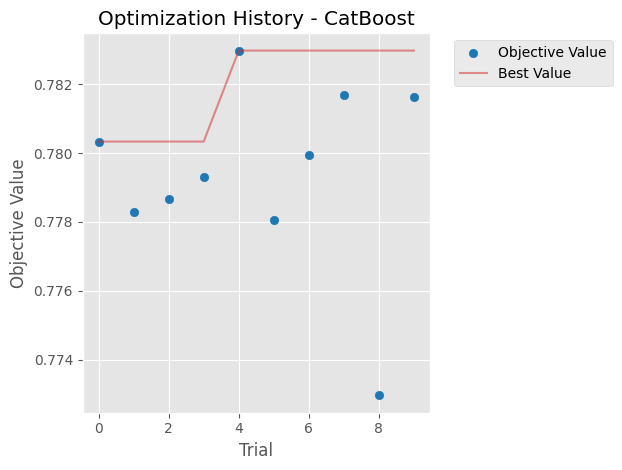

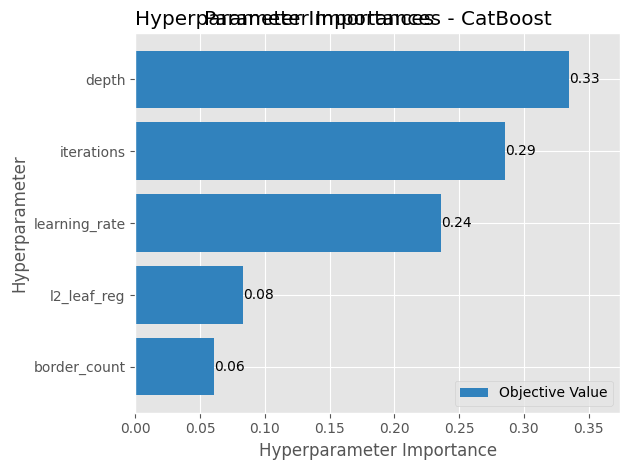


DETAILED CLASSIFICATION REPORT - CatBoost
              precision    recall  f1-score   support

   Certified       0.81      0.78      0.79      3404
      Denied       0.59      0.63      0.61      1692

    accuracy                           0.73      5096
   macro avg       0.70      0.70      0.70      5096
weighted avg       0.74      0.73      0.73      5096



In [49]:
# ==================== VISUALIZATION (Optional) ====================

# Plot Optuna optimization history for best model
import matplotlib.pyplot as plt

fig = optuna.visualization.matplotlib.plot_optimization_history(studies[best_model_name])
plt.title(f'Optimization History - {best_model_name}')
plt.tight_layout()
plt.savefig(f'{best_model_name}_optimization_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot parameter importances
fig = optuna.visualization.matplotlib.plot_param_importances(studies[best_model_name])
plt.title(f'Parameter Importances - {best_model_name}')
plt.tight_layout()
plt.savefig(f'{best_model_name}_param_importances.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed classification report for best model
print("\n" + "="*80)
print(f"DETAILED CLASSIFICATION REPORT - {best_model_name}")
print("="*80)
y_test_pred = best_model_pipeline.predict(X_test)
print(classification_report(y_test, y_test_pred, 
                           target_names=label_encoder.classes_))

## How smote is applied

1. ORIGINAL DATA (before train-test split)
* Total: 25,480 samples
* Certified: 17,018 (67%)
* Denied: 8,462 (33%)

2. AFTER TRAIN-TEST SPLIT (80-20)
* Training Set: 20,384 samples
* Certified: 13,614 (67%)
* Denied: 6,770 (33%)

Test Set: 5,096 samples
* Certified: 3,404 (67%)  ← This is what you see in the report
* Denied: 1,692 (33%)     ← This is what you see in the report

3. SMOTE APPLIED (ONLY on training set, INSIDE pipeline.fit())
* Training Set AFTER SMOTE: ~27,228 samples
* Certified: 13,614 (50%)
* Denied: 13,614 (50%)  ← SMOTE created ~6,844 synthetic samples

Test Set: UNCHANGED (5,096 samples)
* Certified: 3,404 (67%)
* Denied: 1,692 (33%)

### even after seeing equal points of both classes while training still why is such difference in precision , recall on test set?

* Synthetic samples are interpolations between existing minority samples
* They don't capture all the complexity and diversity of real minority class data
* The model learns patterns from synthetic data that may not fully represent real-world minority class 

In [56]:
# ==================== INFERENCE ON NEW DATA ====================

def predict_new_applications(new_data_df):
    
    # Load saved pipeline and encoder
    loaded_pipeline = joblib.load(fr'C:\Users\ASUS\Music\MLOPs_project\artifacts\best_model_{best_model_name.replace(" ", "_")}.pkl')
    loaded_encoder = joblib.load(fr'C:\Users\ASUS\Music\MLOPs_project\artifacts\label_encoder.pkl')
    
    # Make a copy to avoid modifying original
    input_df = new_data_df.copy()
    
    # ===== DATA TYPE VALIDATION AND CORRECTION =====
    # Define expected data types based on your training data
    
    # Numerical columns should be numeric
    numerical_columns = ['no_of_employees', 'prevailing_wage', 'company_age']
    for col in numerical_columns:
        if col in input_df.columns:
            # Convert to numeric, handling errors
            input_df[col] = pd.to_numeric(input_df[col], errors='coerce')
    
    # Categorical columns should be strings
    categorical_columns = ['continent', 'education_of_employee', 'has_job_experience', 
                          'requires_job_training', 'region_of_employment', 
                          'unit_of_wage', 'full_time_position']
    for col in categorical_columns:
        if col in input_df.columns:
            input_df[col] = input_df[col].astype(str)
    
    # Check for missing values created by type conversion
    if input_df.isnull().any().any():
        print("⚠️ Warning: Some values couldn't be converted and are now NaN:")
        print(input_df.isnull().sum()[input_df.isnull().sum() > 0])
    
    # Make predictions
    try:
        predictions_encoded = loaded_pipeline.predict(input_df)
        probabilities = loaded_pipeline.predict_proba(input_df)
        
        # Decode predictions back to original labels
        predictions_decoded = loaded_encoder.inverse_transform(predictions_encoded)
        
        # Create results DataFrame
        results_df = new_data_df.copy()  # Use original input for display
        results_df['predicted_case_status'] = predictions_decoded
        results_df['probability_certified'] = probabilities[:, 0]
        results_df['probability_denied'] = probabilities[:, 1]
        results_df['confidence'] = np.max(probabilities, axis=1)
        
        return results_df
        
    except Exception as e:
        print(f"❌ Prediction failed: {e}")
        print(f"Input data types:\n{input_df.dtypes}")
        raise


# ==================== CORRECTED EXAMPLE DATA ====================

# Example: New applications for inference
new_applications = pd.DataFrame({
    'continent': ['Asia'],
    'education_of_employee': ['High School'],
    'has_job_experience': ['N'],
    'requires_job_training': ['N'],
    'no_of_employees': [14513],  # Integer (correct)
    'region_of_employment': ['West'],
    'prevailing_wage': [592.2029],  # Float, NOT string! (FIXED)
    'unit_of_wage': ['Hour'],
    'full_time_position': ['Y'],
    'company_age': [19]  # Integer (correct)
})

# Make predictions
print("\n" + "="*50)
print("INPUT DATA:")
print("="*50)
print(new_applications)
print(f"\nData types:\n{new_applications.dtypes}")

predictions_result = predict_new_applications(new_applications)

print("\n" + "="*50)
print("PREDICTION RESULTS:")
print("="*50)
print(predictions_result[['predicted_case_status', 'probability_certified', 
                          'probability_denied', 'confidence']])


INPUT DATA:
  continent education_of_employee has_job_experience requires_job_training  \
0      Asia           High School                  N                     N   

   no_of_employees region_of_employment  prevailing_wage unit_of_wage  \
0            14513                 West         592.2029         Hour   

  full_time_position  company_age  
0                  Y           19  

Data types:
continent                 object
education_of_employee     object
has_job_experience        object
requires_job_training     object
no_of_employees            int64
region_of_employment      object
prevailing_wage          float64
unit_of_wage              object
full_time_position        object
company_age                int64
dtype: object

PREDICTION RESULTS:
  predicted_case_status  probability_certified  probability_denied  confidence
0                Denied                0.11145             0.88855     0.88855


## During Training: final_pipeline.fit(X_train, y_train)

1. outlier_handler.fit(X_train, y_train)
   - Learns: lower_bounds, upper_bounds from X_train
   - Then: X_train_transformed = outlier_handler.transform(X_train)
   - y_train: UNTOUCHED, passed as-is
   - Output: (X_train_transformed, y_train) → next step

2. correlation_remover.fit(X_train_transformed, y_train)
   - Learns: columns_to_drop from X_train_transformed
   - Then: X_train_transformed2 = correlation_remover.transform(X_train_transformed)
   - y_train: UNTOUCHED, passed as-is
   - Output: (X_train_transformed2, y_train) → next step

3. preprocessor.fit(X_train_transformed2, y_train)
   - Learns: imputation values, encoding mappings, scaler parameters, power transform lambdas
   - Then: X_train_transformed3 = preprocessor.transform(X_train_transformed2)
   - y_train: UNTOUCHED, passed as-is
   - Output: (X_train_transformed3, y_train) → next step

4. smote.fit_resample(X_train_transformed3, y_train)
   - Learns: Nothing (SMOTE doesn't learn parameters in traditional sense)
   - Creates: Synthetic samples by interpolating between minority class samples
   - Then: X_train_resampled, y_train_resampled = smote.fit_resample(...)
   - BOTH X and y are MODIFIED here!
   - y_train proportion changes: e.g., from [17018, 8462] to [17018, 17018]
   - Output: (X_train_resampled, y_train_resampled) → next step

5. model.fit(X_train_resampled, y_train_resampled)
   - Learns: Model weights/parameters on BALANCED data
   - Trains on: The augmented dataset with synthetic samples

## During Inference: final_pipeline.predict(X_new)

1. X_new_transformed = outlier_handler.transform(X_new)
   - Uses: Learned bounds from training
   - Only transform(), no fit()
   - y is not involved at all in prediction

2. X_new_transformed2 = correlation_remover.transform(X_new_transformed)
   - Uses: Learned columns_to_drop from training
   - Only transform(), no fit()

3. X_new_transformed3 = preprocessor.transform(X_new_transformed2)
   - Uses: Learned imputation values, encodings, scalers from training
   - Only transform(), no fit()

4. SMOTE: COMPLETELY SKIPPED during prediction!
   - imblearn.Pipeline automatically skips samplers during predict()
   - No synthetic samples are created for new data
   - Data flows directly from preprocessor to model

5. predictions = model.predict(X_new_transformed3)
   - Uses: Trained model weights
   - Only predict(), no fit()


## Visual Flow Diagram

### Training Flow:
```
X_train (25,480 rows)  y_train [Certified: 17,018, Denied: 8,462]
    ↓                              ↓
outlier_handler               (untouched)
    ↓                              ↓
correlation_remover           (untouched)
    ↓                              ↓
preprocessor                  (untouched)
    ↓                              ↓
SMOTE ← uses y_train to create synthetic samples
    ↓                              ↓
X_train_resampled          y_train_resampled
(~34,036 rows)             [Certified: 17,018, Denied: 17,018]
    ↓                              ↓
         model.fit(X, y)
```

### Inference Flow:
```
X_new (any size)
    ↓
outlier_handler.transform()
    ↓
correlation_remover.transform()
    ↓
preprocessor.transform()
    ↓
[SMOTE SKIPPED - no resampling during prediction]
    ↓
model.predict()
    ↓
predictions
